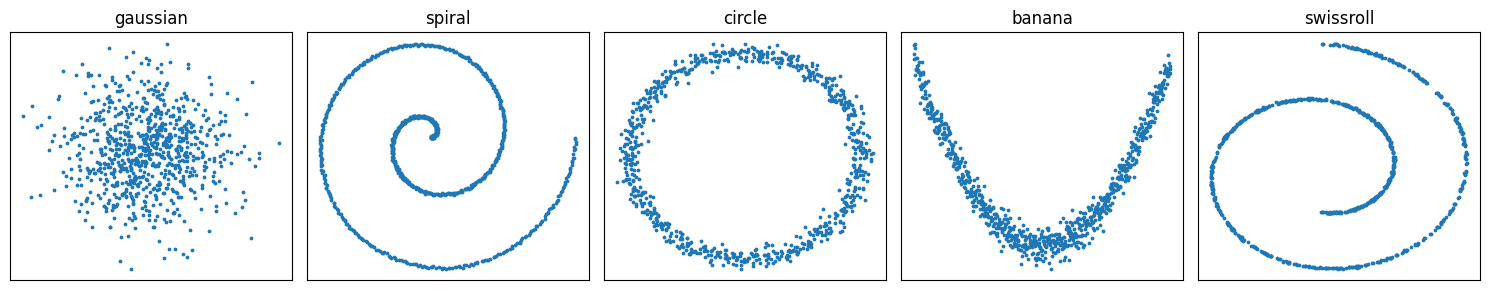

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
import ot  # POT: Python Optimal Transport
from scipy.spatial import procrustes

# -------------------------------
# 0. Function to generate various 2D point clouds
# -------------------------------
def generate_point_cloud(kind='gaussian', n=1000, noise=0.05, random_state=42):
    """
    Generate different distributions of 2D point clouds:
      - kind = 'gaussian': Standard normal distribution (N(0, I_2))
      - kind = 'spiral'  : 2D spiral with added noise
      - kind = 'circle'  : Unit circle with added noise
      - kind = 'banana'  : 2D banana curve (y = x^2) + noise
      - kind = 'swissroll': Swiss roll (then take two dimensions and normalize)

    Parameters:
        kind: str, type of point cloud
        n: int, number of points
        noise: float, noise magnitude
        random_state: int, random seed

    Returns:
        X: numpy array of shape (n, 2)
    """
    np.random.seed(random_state)
    if kind == 'gaussian':
        X = np.random.randn(n, 2)
    elif kind == 'spiral':
        t = np.linspace(0, 4 * np.pi, n)
        x = t * np.cos(t)
        y = t * np.sin(t)
        X = np.stack([x, y], axis=1) + noise * np.random.randn(n, 2)
    elif kind == 'circle':
        t = np.linspace(0, 2 * np.pi, n)
        x = np.cos(t)
        y = np.sin(t)
        X = np.stack([x, y], axis=1) + noise * np.random.randn(n, 2)
    elif kind == 'banana':
        t = np.linspace(-1, 1, n)
        x = t
        y = t**2 + noise * np.random.randn(n)
        X = np.stack([x, y], axis=1)
    elif kind == 'swissroll':
        X3, _ = datasets.make_swiss_roll(n_samples=n, noise=noise, random_state=random_state)
        X = X3[:, [0, 2]]  # Take only x, z dimensions
        X = (X - X.mean(axis=0)) / X.std(axis=0)  # Standardize
    else:
        raise ValueError(f"Unknown point cloud kind: {kind}")
    return X


# -------------------------------
# 1. PCA centering + principal components function
# -------------------------------
def center_and_pca(X, n_components=None):
    """
    Center data X and perform PCA.

    Parameters:
        X: numpy array of shape (n, d), original point cloud
        n_components: int or None, number of principal components to keep; 
                      if None, keep all d components

    Returns:
        Xc: numpy array of shape (n, d), centered data
        axes: numpy array of shape (n_components, d), PCA components (components_)
        projections: numpy array of shape (n, n_components), coordinates projected onto principal components
    """
    Xc = X - X.mean(axis=0)
    d = X.shape[1]
    if n_components is None:
        n_components = d
    pca = PCA(n_components=n_components)
    projections = pca.fit_transform(Xc)  # shape: (n, n_components)
    axes = pca.components_              # shape: (n_components, d)
    return Xc, axes, projections


# -------------------------------
# 2. Compute pairwise Wasserstein cost matrix for 1D projections
# -------------------------------
def pairwise_wasserstein_costs(proj_X, proj_Y):
    """
    Given proj_X and proj_Y (each of shape (n, d)), compute the cost matrix:
      cost_matrix[i, j] = min_{s=±1} W2^2(proj_X[:, i], s * proj_Y[:, j])

    Parameters:
        proj_X: numpy array of shape (n, d), X projected onto d one-dimensional axes
        proj_Y: numpy array of shape (n, d), Y projected onto d one-dimensional axes

    Returns:
        cost_matrix: numpy array of shape (d, d)
    """
    n, d = proj_X.shape
    cost_matrix = np.zeros((d, d))
    for i in range(d):
        x_proj = proj_X[:, i]
        for j in range(d):
            y_proj = proj_Y[:, j]
            # Compare without sign flip
            w2_1 = wasserstein_distance(x_proj, y_proj) ** 2
            # Compare with sign flip (multiply by -1)
            w2_2 = wasserstein_distance(x_proj, -y_proj) ** 2
            cost_matrix[i, j] = min(w2_1, w2_2)
    return cost_matrix


# -------------------------------
# 3. Compute RISWIE distance from cost matrix
# -------------------------------
def riswie_distance_from_cost(cost_matrix):
    """
    Given a cost_matrix of shape (d, d), use Hungarian algorithm to find the optimal matching,
    then compute the RISWIE distance:
      RISWIE = sqrt((1/d) * sum_{matched pairs} cost_matrix[i, j]).

    Returns:
        riswie_dist: float, the RISWIE distance
        (row_ind, col_ind): the row and column indices returned by the Hungarian algorithm
    """
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    m = cost_matrix.shape[0]
    riswie_dist = np.sqrt(total_cost / m)
    return riswie_dist, (row_ind, col_ind)


# -------------------------------
# 4. Diffusion Map embedding function
# -------------------------------
def diffusion_map_embedding(X, m=2, epsilon=None, t=1):
    """
    Perform Diffusion Map embedding on point cloud X, return the top m nontrivial eigenvalues/vectors 
    and the embedding coordinates.

    Parameters:
        X: numpy array of shape (n, d), point cloud
        m: int, number of nontrivial diffusion coordinates to keep
        epsilon: float or None, Gaussian kernel width; if None, use median heuristic
        t: int or float, diffusion time (usually set to 1)

    Returns:
        eigvals: numpy array of shape (m,), the top m nontrivial eigenvalues
        eigvecs: numpy array of shape (n, m), the corresponding eigenvectors
        feat: numpy array of shape (n, m), diffusion coordinates (eigvecs * eigvals^t)
    """
    n = X.shape[0]
    # 1) Compute squared Euclidean distance matrix D
    D = cdist(X, X, metric='sqeuclidean')
    # 2) If epsilon is not specified, use median heuristic
    if epsilon is None:
        eps = np.median(D[D > 0])
        epsilon = eps if eps > 0 else 1.0
    # 3) Construct Gaussian kernel matrix K_ij = exp(-D_ij / epsilon)
    K = np.exp(-D / epsilon)
    # 4) Symmetric normalization: P = D^{-1/2} K D^{-1/2}
    d = K.sum(axis=1)
    D_inv_sqrt = np.diag(1 / np.sqrt(d + 1e-12))
    P = D_inv_sqrt @ K @ D_inv_sqrt
    # 5) Eigen decomposition of P
    eigvals_all, eigvecs_all = eigh(P)
    # 6) Sort eigenvalues in descending order
    idx = np.argsort(eigvals_all)[::-1]
    eigvals_all = eigvals_all[idx]
    eigvecs_all = eigvecs_all[:, idx]
    # 7) Skip the trivial first eigenvalue (~1) and take the next m
    eigvals = eigvals_all[1 : m + 1]
    eigvecs = eigvecs_all[:, 1 : m + 1]
    # 8) Compute diffusion coordinates
    feat = eigvecs * (eigvals[np.newaxis, :] ** t)
    return eigvals, eigvecs, feat


# -------------------------------
# 5. Classic Sliced Wasserstein distance
# -------------------------------
def sliced_wasserstein_distance(X, Y, n_proj=100):
    """
    Compute Sliced Wasserstein distance via multiple random 1D projections.

    Parameters:
        X, Y: numpy arrays each of shape (n, d), point clouds
        n_proj: int, number of random projection directions

    Returns:
        sw_dist: float, sqrt(mean_k(W2^2(X_proj_k, Y_proj_k)))
    """
    d = X.shape[1]
    sw2_list = []
    for _ in range(n_proj):
        # Sample a random direction vector of length d
        direction = np.random.randn(d)
        direction /= np.linalg.norm(direction)
        # Project onto that direction
        X_proj = X @ direction
        Y_proj = Y @ direction
        # Compute 1D Wasserstein distance and square it
        w2 = wasserstein_distance(X_proj, Y_proj) ** 2
        sw2_list.append(w2)
    sw2_mean = np.mean(sw2_list)
    return np.sqrt(sw2_mean)


# -------------------------------
# 6. Gromov-Wasserstein distance (avoid sqrt negative/NaN issues)
# -------------------------------
def gromov_wasserstein_distance(
    X, Y,
    loss_fun='square_loss',
    max_iter=50,
    tol=1e-5,
    eps_diagonal=1e-8
):
    """
    Compute the Gromov-Wasserstein distance between two point clouds, ensuring no NaN is returned.

    Steps:
      1. Compute Euclidean distance matrices cdist(X, X) and cdist(Y, Y)
      2. Pass max_iter and tol to POT so it doesn't iterate indefinitely
      3. Use try/except to catch any exceptions
      4. Clip negative values and handle NaN
      5. Return sqrt(cost)

    Parameters:
      X, Y: numpy arrays of shape (n, d), point clouds
      loss_fun: str, name of the loss function supported by POT (default 'square_loss')
      max_iter: int, maximum iterations for POT (default 50)
      tol: float, convergence tolerance for POT (default 1e-5)
      eps_diagonal: float, small jitter on diagonal to avoid singular rows/columns

    Returns:
      gw_dist: float, sqrt(GW^2). Never returns NaN; returns 0.0 if an exception or negative value arises.
    """
    n1, n2 = X.shape[0], Y.shape[0]

    # 1. Compute Euclidean distance matrices
    C1 = cdist(X, X, metric='euclidean')
    C2 = cdist(Y, Y, metric='euclidean')
    # Add slight jitter on diagonals to avoid rows/columns of all zeros
    np.fill_diagonal(C1, C1.diagonal() + eps_diagonal)
    np.fill_diagonal(C2, C2.diagonal() + eps_diagonal)

    # 2. Construct uniform distribution vectors
    p1 = np.ones(n1) / n1
    p2 = np.ones(n2) / n2

    # 3. Call POT's gromov_wasserstein2 inside try/except
    try:
        gw2 = ot.gromov.gromov_wasserstein2(
            C1, C2, p1, p2, loss_fun,
            max_iter=max_iter,
            tol=tol,
            verbose=False  # Do not print iteration details
        )
    except Exception:
        # If any exception occurs, set gw2 = 0.0
        gw2 = 0.0

    # 4. Clip negative or NaN values to 0.0
    if np.isnan(gw2) or gw2 < 0:
        gw2 = 0.0

    # 5. Return sqrt(gw2)
    return np.sqrt(gw2)


# -------------------------------
# 7. Standard OT distance (Earth Mover's Distance)
# -------------------------------
def standard_ot_distance(X, Y):
    """
    Compute the OT (Earth Mover's) distance between two point clouds (without taking the square root).

    Parameters:
        X, Y: numpy arrays each of shape (n, d), point clouds (assume n is equal)

    Returns:
        ot_cost: float, sum_{i,j} T_{ij} * cost_{ij}
    """
    n = X.shape[0]
    cost_mat = cdist(X, Y, metric='euclidean')
    p = np.ones(n) / n
    q = np.ones(n) / n
    T = ot.emd(p, q, cost_mat)
    ot_cost = np.sum(T * cost_mat)
    return ot_cost


# -------------------------------
# 8. Procrustes distance
# -------------------------------
def procrustes_distance(X, Y):
    """
    Use scipy.spatial.procrustes to compute the Procrustes disparity between two point clouds,
    then return sqrt(disparity) as the distance.
    """
    mtx1, mtx2, disparity = procrustes(X, Y)
    return np.sqrt(disparity)


# -------------------------------
# 9. Centroid distance
# -------------------------------
def centroid_distance(X, Y):
    """
    Compute the Euclidean distance between the centroids of two point clouds.
    """
    return np.linalg.norm(X.mean(axis=0) - Y.mean(axis=0))


# ===============================
# All helper functions are now defined.
# ===============================
# The examples below show how to use these functions to evaluate multiple random translations 
# and visualize the results.
# ===============================


if __name__ == "__main__":
    # -------------------------------
    # Example: Visualize various point clouds
    # -------------------------------
    kinds = ['gaussian', 'spiral', 'circle', 'banana', 'swissroll']
    plt.figure(figsize=(15, 3))
    for i, k in enumerate(kinds):
        X_temp = generate_point_cloud(kind=k, n=800, noise=0.05, random_state=0)
        plt.subplot(1, 5, i + 1)
        plt.scatter(X_temp[:, 0], X_temp[:, 1], s=3)
        plt.title(k)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Example: Evaluate multiple random translations on a 'gaussian' point cloud
    # -------------------------------
    def evaluate_translations(
        kind='gaussian',
        n_points=1000,
        noise=0.05,
        random_state=42,
        n_translations=10,
        max_shift=5.0
    ):
        """
        For a given type of point cloud, generate multiple translations and evaluate distances by each method.
        Returns a dictionary: {method_name: [list of distances]}
        """
        np.random.seed(random_state)

        # 1. Generate the original point cloud X
        X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)

        # 2. Precompute PCA and Diffusion embeddings for X
        Xc, axes_X, proj_X = center_and_pca(X)                        # PCA embedding
        eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])  # Diffusion embedding

        # 3. Prepare a dictionary to store distances for each method
        methods = [
            'RISWIE-PCA',
            'RISWIE-Diffusion',
            'SlicedW',
            'GromovW',
            'StandardOT',
            'Procrustes',
            'Centroid'
        ]
        results = {m: [] for m in methods}

        # 4. Loop over multiple random translations
        for i in range(n_translations):
            # Random translation vector
            t = np.random.uniform(-max_shift, max_shift, size=2)
            Y = X + t  # Translated point cloud

            # --- RISWIE-PCA ---
            Yc, axes_Y, proj_Y = center_and_pca(Y)
            cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
            riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
            results['RISWIE-PCA'].append(riswie_pca)

            # --- RISWIE-Diffusion ---
            eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
            cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
            riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
            results['RISWIE-Diffusion'].append(riswie_diff)

            # --- Sliced Wasserstein ---
            sw = sliced_wasserstein_distance(X, Y, n_proj=100)
            results['SlicedW'].append(sw)

            # --- Gromov-Wasserstein ---
            gw = gromov_wasserstein_distance(X, Y)
            results['GromovW'].append(gw)

            # --- Standard OT ---
            ot_d = standard_ot_distance(X, Y)
            results['StandardOT'].append(ot_d)

            # --- Procrustes ---
            proc = procrustes_distance(X, Y)
            results['Procrustes'].append(proc)

            # --- Centroid ---
            cent = centroid_distance(X, Y)
            results['Centroid'].append(cent)

        return results

    # Run example: 10 random translations for 'gaussian', translation range [-5, 5]
    results_gauss = evaluate_translations(
        kind='gaussian',
        n_points=1000,
        noise=0,
        random_state=42,
        n_translations=10,
        max_shift=5.0
    )

    # Print distances for each method over 10 translations
    for method, vals in results_gauss.items():
        print(f"{method}: {np.round(vals, 4)}")

    # -------------------------------
    # Example: Visualize ||translation|| vs. distance relationships
    # -------------------------------
    # Note: We need to record each translation magnitude ||t|| and plot distance(t).

    def evaluate_and_plot(kind='gaussian', n_points=1000, noise=0.05,
                          random_state=42, n_translations=20, max_shift=5.0):
        """
        For a given point cloud type, perform multiple random translations,
        record the norm ||t|| and distances by each method, then plot ||t|| vs. distance.
        """
        np.random.seed(random_state)

        # 1. Generate the original point cloud X and precompute embeddings
        X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
        Xc, axes_X, proj_X = center_and_pca(X)
        eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

        # 2. Prepare data structures for results
        methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
                   'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
        distances = {m: [] for m in methods}
        shifts = []

        # 3. Loop over multiple translations
        for i in range(n_translations):
            t = np.random.uniform(-max_shift, max_shift, size=2)
            Y = X + t
            shifts.append(np.linalg.norm(t))  # Record ||t||

            # RISWIE-PCA
            Yc, axes_Y, proj_Y = center_and_pca(Y)
            cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
            riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
            distances['RISWIE-PCA'].append(riswie_pca)

            # RISWIE-Diffusion
            eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
            cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
            riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
            distances['RISWIE-Diffusion'].append(riswie_diff)

            # Sliced Wasserstein
            sw = sliced_wasserstein_distance(X, Y, n_proj=100)
            distances['SlicedW'].append(sw)

            # Gromov-Wasserstein
            gw = gromov_wasserstein_distance(X, Y)
            distances['GromovW'].append(gw)

            # Standard OT
            ot_d = standard_ot_distance(X, Y)
            distances['StandardOT'].append(ot_d)

            # Procrustes
            proc = procrustes_distance(X, Y)
            distances['Procrustes'].append(proc)

            # Centroid
            cent = centroid_distance(X, Y)
            distances['Centroid'].append(cent)


In [3]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")

def evaluate_and_plot(kind='gaussian', n_points=1000, noise=0.05,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    

        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [4]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")

def evaluate_and_plot(kind='gaussian', n_points=1000, noise=0.2,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)



RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [5]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")

def evaluate_and_plot(kind='spiral', n_points=1000, noise=0,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [6]:

# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


def evaluate_and_plot(kind='spiral', n_points=1000, noise=0.05,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)






RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [7]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")

def evaluate_and_plot(kind='spiral', n_points=1000, noise=0.2,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [8]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")

def evaluate_and_plot(kind='banana', n_points=1000, noise=0,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [9]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


def evaluate_and_plot(kind='banana', n_points=1000, noise=0.02,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)






RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [10]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


def evaluate_and_plot(kind='banana', n_points=1000, noise=0.5,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [11]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


def evaluate_and_plot(kind='swissroll', n_points=1000, noise=0,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [12]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


def evaluate_and_plot(kind='swissroll', n_points=1000, noise=0.02,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]


In [13]:
# Print distances for each method over 10 translations
for method, vals in results_gauss.items():
    print(f"{method}: {np.round(vals, 4)}")


def evaluate_and_plot(kind='swissroll', n_points=1000, noise=0.5,
                      random_state=42, n_translations=20, max_shift=5.0):
    """
    For a given type of point cloud, perform multiple random translations,
    record the norm of each translation vector t and the distances computed
    by each method, and then plot ||t|| vs. distance (one curve per method).
    """
    np.random.seed(random_state)

    # 1. Generate the original point cloud X and precompute its embeddings
    X = generate_point_cloud(kind=kind, n=n_points, noise=noise, random_state=random_state)
    Xc, axes_X, proj_X = center_and_pca(X)
    eigvals_X, eigvecs_X, feat_X = diffusion_map_embedding(X, m=X.shape[1])

    # 2. Prepare storage for results
    methods = ['RISWIE-PCA', 'RISWIE-Diffusion', 'SlicedW',
               'GromovW', 'StandardOT', 'Procrustes', 'Centroid']
    distances = {m: [] for m in methods}
    shifts = []

    # 3. Loop over multiple random translations
    for i in range(n_translations):
        # Generate a random translation vector and apply it
        t = np.random.uniform(-max_shift, max_shift, size=2)
        Y = X + t
        shifts.append(np.linalg.norm(t))  # Record ||t||

        # --- RISWIE-PCA ---
        Yc, axes_Y, proj_Y = center_and_pca(Y)
        cost_mat_pca = pairwise_wasserstein_costs(proj_X, proj_Y)
        riswie_pca, _ = riswie_distance_from_cost(cost_mat_pca)
        distances['RISWIE-PCA'].append(riswie_pca)

        # --- RISWIE-Diffusion ---
        eigvals_Y, eigvecs_Y, feat_Y = diffusion_map_embedding(Y, m=proj_X.shape[1])
        cost_mat_diff = pairwise_wasserstein_costs(feat_X, feat_Y)
        riswie_diff, _ = riswie_distance_from_cost(cost_mat_diff)
        distances['RISWIE-Diffusion'].append(riswie_diff)

        # --- Sliced Wasserstein ---
        sw = sliced_wasserstein_distance(X, Y, n_proj=100)
        distances['SlicedW'].append(sw)

        # --- Gromov-Wasserstein ---
        gw = gromov_wasserstein_distance(X, Y)
        distances['GromovW'].append(gw)

        # --- Standard OT ---
        ot_d = standard_ot_distance(X, Y)
        distances['StandardOT'].append(ot_d)

        # --- Procrustes ---
        proc = procrustes_distance(X, Y)
        distances['Procrustes'].append(proc)

        # --- Centroid Distance ---
        cent = centroid_distance(X, Y)
        distances['Centroid'].append(cent)

    


        

RISWIE-PCA: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
RISWIE-Diffusion: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
SlicedW: [3.165  2.1133 1.1517 0.8907 2.7697 2.2997 0.9854 3.4543 3.4155 3.801 ]
GromovW: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
StandardOT: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
Procrustes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Centroid: [4.4382 2.8915 1.5843 1.3524 3.7601 3.2149 1.3972 4.6107 5.0354 5.1269]
